In [81]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

In [5]:
import yfinance as yf

In [13]:
start_date = '2010-01-01'
end_date = '2021-07-01'
names = ['AUDUSD', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY']

In [17]:
df = {}
for i in range(len(names)):
    df[names[i]] = yf.download(names[i]+'=X', start=start_date, end=end_date)   
    df[names[i]] = df[names[i]][['Close']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [71]:
daily_returns = pd.DataFrame()
for i in range(len(names)):
    df[names[i]][names[i]] = df[names[i]]['Close'].pct_change(1)
    df[names[i]] = df[names[i]].dropna()
    daily_returns[names[i]] = df[names[i]][names[i]]
daily_returns['Date'] = df[names[i]]['Date']
daily_returns = daily_returns.dropna()
daily_returns.set_index('Date', inplace=True)

In [72]:
daily_returns

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
Date,,,,,,,
2010-01-11,0.005020,0.006951,0.005543,0.006678,0.003884,-0.006741,-0.006130
2010-01-12,-0.009941,-0.002389,0.002407,-0.004873,0.005223,0.002065,-0.010989
2010-01-13,0.004067,0.003268,0.008322,0.002591,-0.008083,-0.001178,0.003876
2010-01-14,0.007730,-0.001653,0.002940,0.002821,-0.007179,0.000983,-0.001816
2010-01-15,-0.009319,-0.007512,-0.003921,-0.005390,0.005472,0.006185,-0.005665
...,...,...,...,...,...,...,...
2021-06-21,0.004118,-0.003337,-0.008719,-0.009451,-0.006418,-0.000523,-0.001124
2021-06-22,0.002643,0.003276,0.007837,0.005358,-0.004850,0.000022,0.001570
2021-06-23,0.002598,0.002029,0.001760,0.004534,-0.000544,-0.001568,0.002537


In [73]:
#-- Get annualised mean returns
mus = (1+daily_returns.mean())**252 - 1

#-- Get covariances
#- Multiply by 252 to annualise it (square root time for volatility but no square root for variance)
#- Note: 252 trading days in a year
#- https://quant.stackexchange.com/questions/4753/annualized-covariance
cov = daily_returns.cov()*252

In [74]:
mus

AUDUSD   -0.010979
EURUSD   -0.011991
GBPUSD   -0.007956
NZDUSD    0.002549
USDCAD    0.018227
USDCHF   -0.003428
USDJPY    0.019363
dtype: float64

In [75]:
#- How many assests to include in each portfolio
n_assets = 7
#-- How many portfolios to generate
n_portfolios = 1000

#-- Initialize empty list to store mean-variance pairs for plotting
mean_variance_pairs = []

np.random.seed(75)
#-- Loop through and generate lots of random portfolios
for i in range(n_portfolios):
    #- Choose assets randomly without replacement
    assets = np.random.choice(list(daily_returns.columns), n_assets, replace=False)
    #- Choose weights randomly
    weights = np.random.rand(n_assets)
    #- Ensure weights sum to 1
    weights = weights/sum(weights)

    #-- Loop over asset pairs and compute portfolio return and variance
    #- https://quant.stackexchange.com/questions/43442/portfolio-variance-explanation-for-equation-investments-by-zvi-bodie
    portfolio_E_Variance = 0
    portfolio_E_Return = 0
    for i in range(len(assets)):
        portfolio_E_Return += weights[i] * mus.loc[assets[i]]
        for j in range(len(assets)):
            #-- Add variance/covariance for each asset pair
            #- Note that when i==j this adds the variance
            portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]
            
    #-- Add the mean/variance pairs to a list for plotting
    mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])

In [76]:
len(mean_variance_pairs)

1000

In [77]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
#fig.update_xaxes(range=[0.18, 0.32])
#fig.update_yaxes(range=[0.02,0.27])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

In [78]:
#-- Create random portfolio weights and indexes
#- How many assests in the portfolio
n_assets = 7

mean_variance_pairs = []
weights_list=[]
tickers_list=[]

for i in tqdm(range(10000)):
    next_i = False
    while True:
        #- Choose assets randomly without replacement
        assets = np.random.choice(list(daily_returns.columns), n_assets, replace=False)
        #- Choose weights randomly ensuring they sum to one
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        #-- Loop over asset pairs and compute portfolio return and variance
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * cov.loc[assets[i], assets[j]]

        #-- Skip over dominated portfolios
        for R,V in mean_variance_pairs:
            if (R > portfolio_E_Return) & (V < portfolio_E_Variance):
                next_i = True
                break
        if next_i:
            break

        #-- Add the mean/variance pairs to a list for plotting
        mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.11it/s]


In [79]:
len(mean_variance_pairs)

33

In [80]:
#-- Plot the risk vs. return of randomly generated portfolios
#-- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
#fig.update_xaxes(range=[0.18, 0.35])
#fig.update_yaxes(range=[0.05,0.29])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

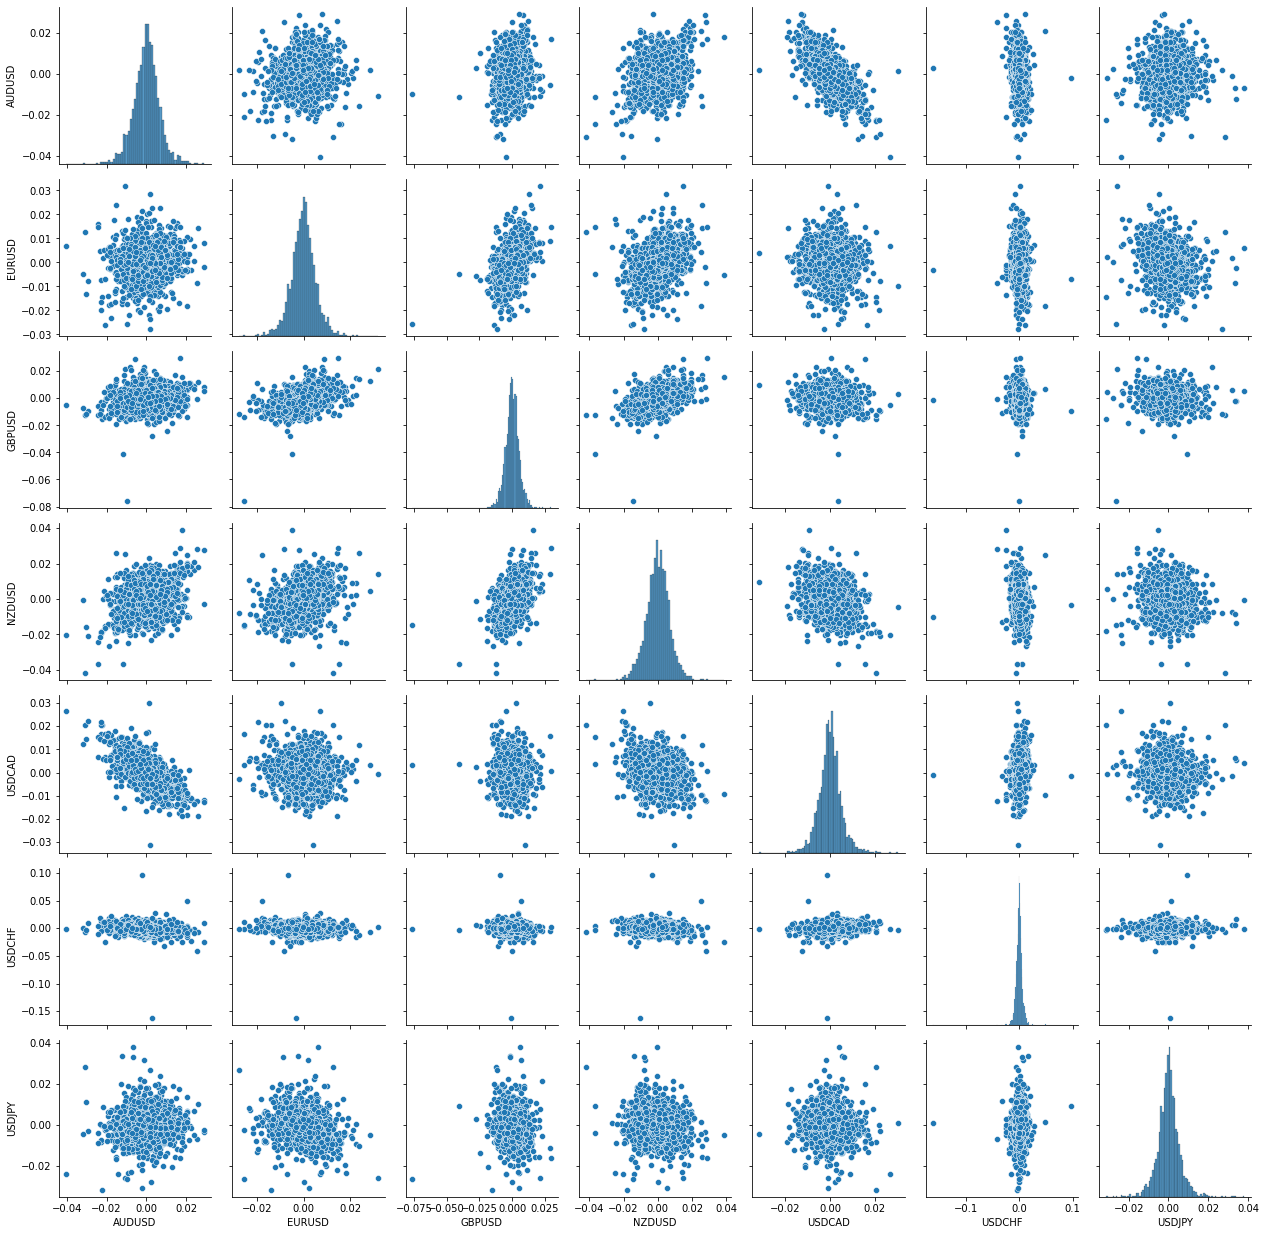

In [82]:
import seaborn as sns
g = sns.PairGrid(daily_returns)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [86]:
prueba_corr = daily_returns
prueba_corr = prueba_corr.reset_index()

In [87]:
prueba_corr

,Date,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
0,2010-01-11,0.005020,0.006951,0.005543,0.006678,0.003884,-0.006741,-0.006130
1,2010-01-12,-0.009941,-0.002389,0.002407,-0.004873,0.005223,0.002065,-0.010989
2,2010-01-13,0.004067,0.003268,0.008322,0.002591,-0.008083,-0.001178,0.003876
3,2010-01-14,0.007730,-0.001653,0.002940,0.002821,-0.007179,0.000983,-0.001816
4,2010-01-15,-0.009319,-0.007512,-0.003921,-0.005390,0.005472,0.006185,-0.005665
...,...,...,...,...,...,...,...,...
2980,2021-06-21,0.004118,-0.003337,-0.008719,-0.009451,-0.006418,-0.000523,-0.001124
2981,2021-06-22,0.002643,0.003276,0.007837,0.005358,-0.004850,0.000022,0.001570
2982,2021-06-23,0.002598,0.002029,0.001760,0.004534,-0.000544,-0.001568,0.002537
2983,2021-06-24,0.001008,-0.000298,0.001257,0.003931,0.001544,0.003185,0.003235


In [ ]:
prueba_corr = prueba_corr.drop('Date', 1)

In [90]:
prueba_corr

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
0,0.005020,0.006951,0.005543,0.006678,0.003884,-0.006741,-0.006130
1,-0.009941,-0.002389,0.002407,-0.004873,0.005223,0.002065,-0.010989
2,0.004067,0.003268,0.008322,0.002591,-0.008083,-0.001178,0.003876
3,0.007730,-0.001653,0.002940,0.002821,-0.007179,0.000983,-0.001816
4,-0.009319,-0.007512,-0.003921,-0.005390,0.005472,0.006185,-0.005665
...,...,...,...,...,...,...,...
2980,0.004118,-0.003337,-0.008719,-0.009451,-0.006418,-0.000523,-0.001124
2981,0.002643,0.003276,0.007837,0.005358,-0.004850,0.000022,0.001570
2982,0.002598,0.002029,0.001760,0.004534,-0.000544,-0.001568,0.002537
2983,0.001008,-0.000298,0.001257,0.003931,0.001544,0.003185,0.003235


In [91]:
cormat

,AUDUSD,EURUSD,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY
0,0.005020,0.006951,0.005543,0.006678,0.003884,-0.006741,-0.006130
1,-0.009941,-0.002389,0.002407,-0.004873,0.005223,0.002065,-0.010989
2,0.004067,0.003268,0.008322,0.002591,-0.008083,-0.001178,0.003876
3,0.007730,-0.001653,0.002940,0.002821,-0.007179,0.000983,-0.001816
4,-0.009319,-0.007512,-0.003921,-0.005390,0.005472,0.006185,-0.005665
...,...,...,...,...,...,...,...
2980,0.004118,-0.003337,-0.008719,-0.009451,-0.006418,-0.000523,-0.001124
2981,0.002643,0.003276,0.007837,0.005358,-0.004850,0.000022,0.001570
2982,0.002598,0.002029,0.001760,0.004534,-0.000544,-0.001568,0.002537
2983,0.001008,-0.000298,0.001257,0.003931,0.001544,0.003185,0.003235


<AxesSubplot:>

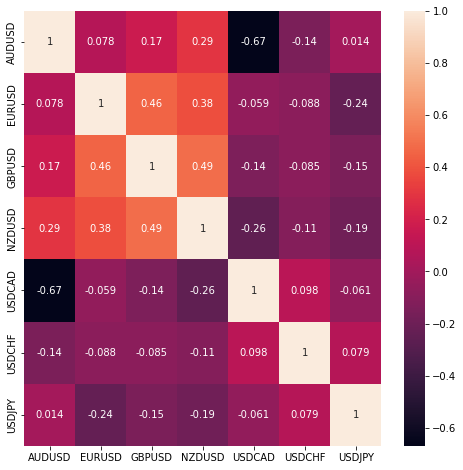

In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
cormat = prueba_corr.corr()
round(cormat,2)
sns.heatmap(cormat,annot=True)
# No podemos meter como variables de entrada Close Low High y Open, se tendrá que meter 1